# 기본 Chatbot을 이용해서 Langraph 구현하기

StateGraph : 기본 챗봇의 구조를 "상태 머신"으로 정의한다.   
Nodes : 우리의 챗봇을 호출할 수 있는 LLM과 함수를 작성하기위한 Node를 추가   
Edge : 함수들 사이를 봇이 어떻게 전환할 것인지를 특정하기 위한 Edge를 추가    

## 라이브러리 설치

In [1]:
%%capture

# update or install the necessary libraries

%pip install langgraph
%pip install --upgrade \
    langchain==0.1.14 \
    langchain-core==0.1.31 \
    langchain-openai==0.1.3
%pip install --upgrade python-dotenv

In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI()

## 기본 코드 작성

### StateGraph 정의 

- State : 애플리케이션의 현재 상태를 나타내는 공유 데이터 구조 
  - 전체 워크플로우의 컨텍스트 유지; 노드 간 정보 공유; TypedDict 또는 Pydantic BaseModel로 정의 

In [4]:
from langgraph.graph import StateGraph, START, END
# Python의 typing 모듈에서 TypedDict를 가져옵니다.
# TypedDict는 딕셔너리의 키와 값의 타입을 미리 정의할 수 있게 해주는 도구입니다.
from typing import TypedDict

# 그래프의 상태를 정의하는 클래스
# MyState라는 새로운 클래스를 만듭니다.
# 이 클래스는 TypedDict를 기반으로 합니다.
class MyState(TypedDict):
    # MyState 클래스 안에 counter라는 항목을 만듭니다.
    # 이 항목은 정수(int) 타입입니다.
    counter: int

# StateGraph 인스턴스 생성
graph = StateGraph(MyState)

# 카운터를 증가시키는 노드 함수 정의
def increment(state):
    return {"counter": state["counter"] + 1}

# 'increment' 노드 추가
graph.add_node("increment", increment)

# START에서 'increment' 노드로 엣지 추가
graph.add_edge(START, "increment")

# 'increment' 노드에서 END로 엣지 추가
graph.add_edge("increment", END)

# 그래프 컴파일
increament_graph = graph.compile()

# 그래프 실행
result = increament_graph.invoke({"counter": 0})
print(result)

{'counter': 1}


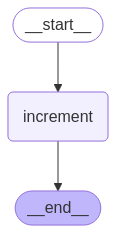

In [5]:
from IPython.display import Image, display

try:
    display(Image(increament_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Node / Edge 정의 

Node들은 작업의 단위(Unit Of Work)를 나타낸다. 

- Nodes: 실제 작업을 수행하는 Python 항수들 
- Edges :노드 간의 연결을 정의 하는 요소 

In [6]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

graph_builder.add_edge(START, "chatbot")

graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

### Graph 확인하기 

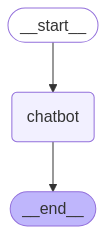

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# Multi-Agent Supvisor 

- [Agent Supervisor](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/)

#### 상태 정의

In [8]:
from typing import TypedDict

class QuestionState(TypedDict):
    messages: str

#### Agent / Tool Prompt 정의 

In [9]:
question_agent_prompt = """
your are a question agent app only can do an operation if you need other then call other app. Use Korean Language.
"""

mesage_context_prompt = """
This tool is a wrapper for answering messages.

**VERY IMPORTANT**  
Your input to this tool MUST message and string type. 

**Don't change result of json result by your self, Just return exact result.**
**Response format :** should be in JSON String.
"""

In [10]:
from langchain_core.tools import StructuredTool
from langchain_core.pydantic_v1 import BaseModel, Field

class MessageContext(BaseModel):
    messages: str = Field(..., description="messages")

def anwser_tool(messages) -> dict:
    result = llm.invoke(messages)
    print(result)

    return {
        "messages" : [
            result
        ],
    }

agent_tools = [
                StructuredTool.from_function(
                    anwser_tool, 
                    name="anwser", 
                    description=mesage_context_prompt, 
                    args_schema=MessageContext
                )
            ]

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
from langchain_core.messages import HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.agents import create_tool_calling_agent, AgentExecutor

def answer_question_agent_dict(state, agent, name):
    result = agent.invoke(state)

    # 기본적으로 출력되는 메시지
    output_state = {
        "messages": [HumanMessage(content=result["output"], name=name)]
    }
    return output_state


def answer_question_agent(llm, tools, system_message: str):
    """Create an app."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    agent = create_tool_calling_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

In [12]:
from langchain_core.messages import HumanMessage
from langgraph.constants import START, END
from langgraph.graph import StateGraph
import functools
  

workflow_graph_builder = StateGraph(QuestionState)
    
workflow_graph_builder.add_node(
    "answer_question", 
    functools.partial(
        answer_question_agent_dict, 
        agent=answer_question_agent(
            llm=llm,
            tools=agent_tools, 
            system_message=question_agent_prompt
        ), 
        name="answer_question"
    )
)

workflow_graph_builder.add_edge(START, "answer_question")
workflow_graph_builder.add_edge("answer_question", END)

workflow_app = workflow_graph_builder.compile()

result = workflow_app.invoke({
    "messages": [HumanMessage(content="안녕하세요?")]
})

print(result)

{'messages': [HumanMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={}, name='answer_question')]}
